# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment=None
pd.options.display.max_columns=999
import lightgbm as lgb
from sklearn import metrics, preprocessing, model_selection

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

# Reading train, test and submission file

In [ ]:
train = pd.read_csv("train_Df64byy.csv")
test = pd.read_csv("test_YCcRUnU.csv")
sample = pd.read_csv("sample_submission_QrCyCoT.csv")

In [ ]:
train.shape, test.shape

((50882, 14), (21805, 13))

In [ ]:
train.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

# EDA

In [ ]:
def draw_distribution(feature):
    
    plt.figure(figsize=(15,7))
    
    #if train[feature].dtype == 'object':
    sns.countplot(x=feature, data=df, hue='is_train')
        #sns.countplot(train[feature].dropna())
        #sns.countplot(test[feature].dropna())
    #else:    
        # sns.distplot(train[feature].dropna())
        # sns.distplot(test[feature].dropna())

In [ ]:
train["is_train"] = 1
test["is_train"] = 0

In [ ]:
df = pd.concat([train, test],axis=0)

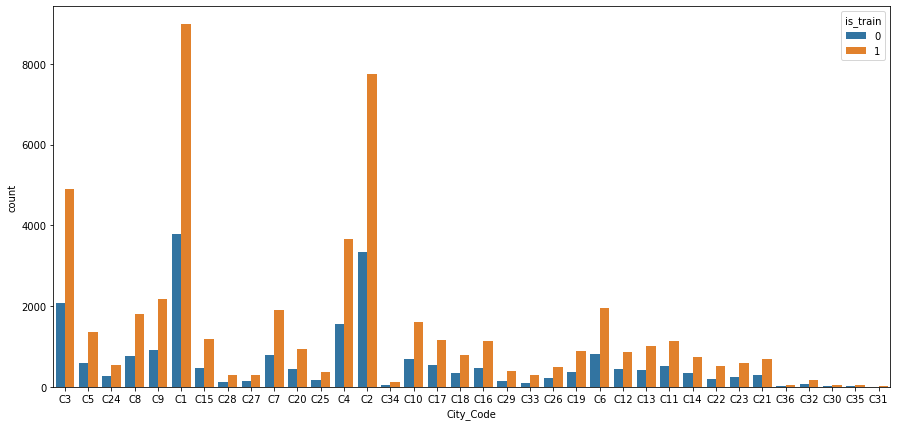

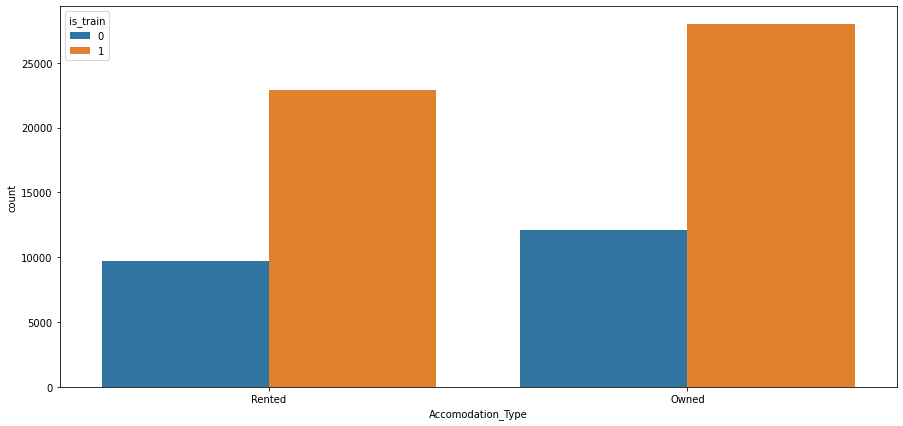

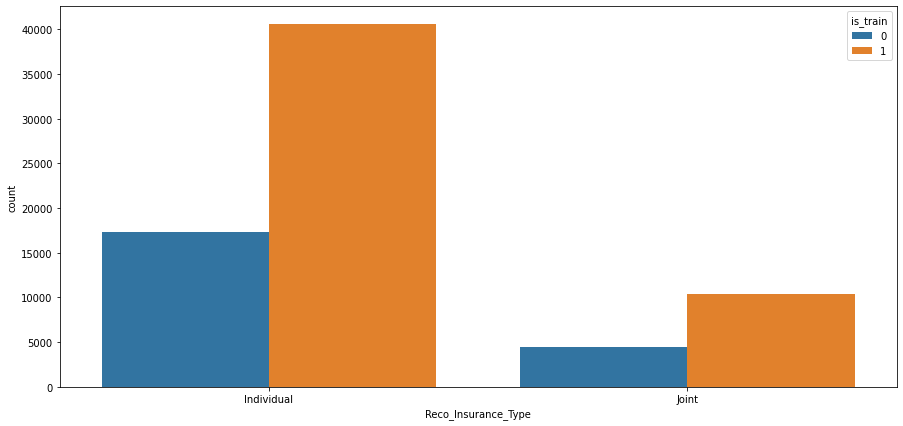

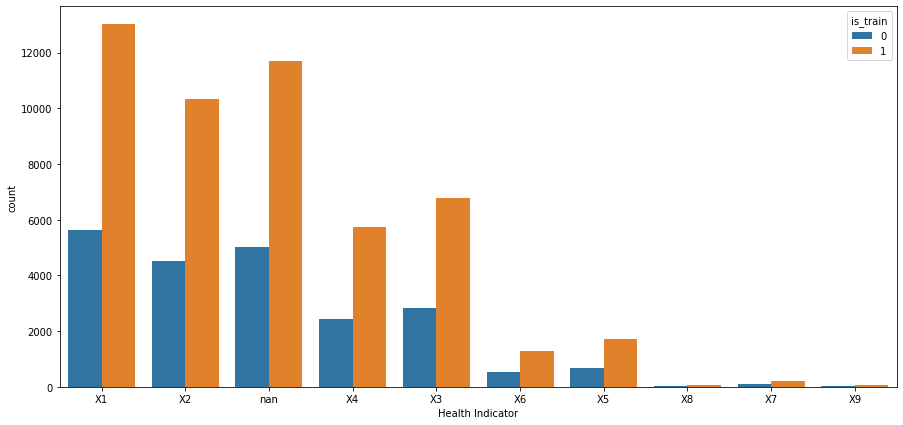

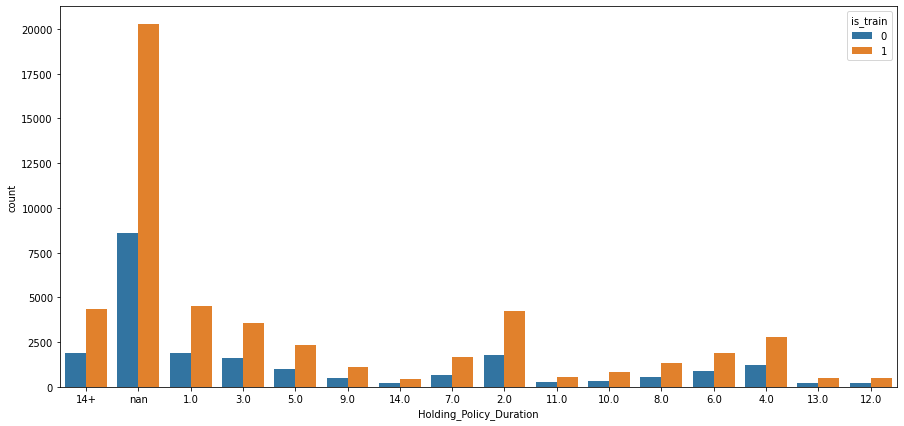

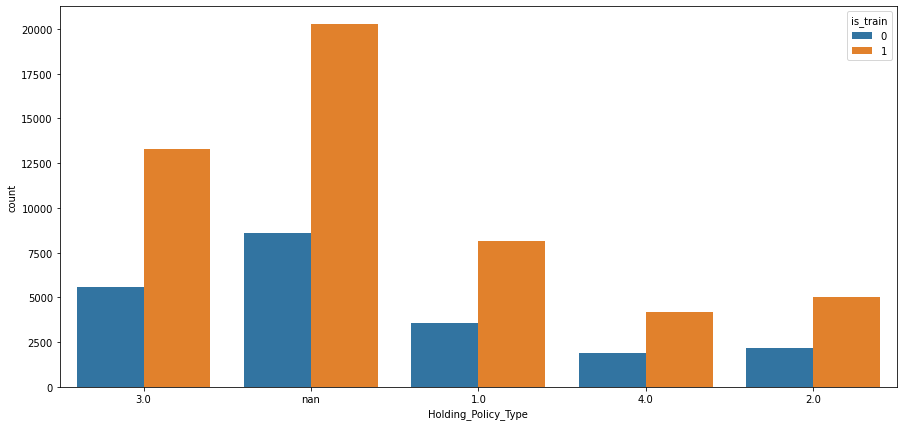

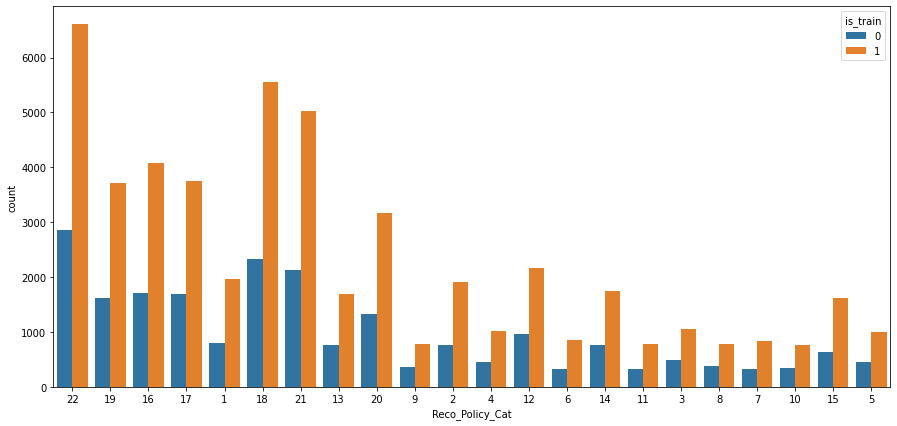

In [ ]:
for i in ['City_Code','Accomodation_Type',
       'Reco_Insurance_Type','Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat']:
       df[i] = df[i].astype("str")
       draw_distribution(i)

     

In [ ]:
train.drop("is_train",axis=1,inplace=True)
test.drop("is_train",axis=1,inplace=True)

# Data Preprocessing

In [ ]:
### Creating Buckets according to the response rate

train = train.assign(HI_bucket=1)
train.loc[train['Health Indicator'].isin(['X1','X2','X3']), 'HI_bucket'] = 1
train.loc[train['Health Indicator'].isin(['X4','X5','X6']), 'HI_bucket'] = 2
train.loc[train['Health Indicator'].isin(['X7','X8','X9']), 'HI_bucket'] = 3

test = test.assign(HI_bucket=1)
test.loc[test['Health Indicator'].isin(['X1','X2','X3']), 'HI_bucket'] = 1
test.loc[test['Health Indicator'].isin(['X4','X5','X6']), 'HI_bucket'] = 2
test.loc[test['Health Indicator'].isin(['X7','X8','X9']), 'HI_bucket'] = 3

train = train.assign(HPD_bucket=1)
train.loc[train['Holding_Policy_Duration'].isin(['1.0','2.0','3.0']), 'HPD_bucket'] = 1
train.loc[train['Holding_Policy_Duration'].isin(['4.0','5.0','6.0','7.0']), 'HPD_bucket'] = 2
train.loc[train['Holding_Policy_Duration'].isin(['8.0','9.0','10.0']), 'HPD_bucket'] = 3
train.loc[train['Holding_Policy_Duration'].isin(['11.0','12.0','13.0','14.0']), 'HPD_bucket'] = 4
train.loc[train['Holding_Policy_Duration'].isin(['14.0']), 'HPD_bucket'] = 5

test = test.assign(HPD_bucket=1)
test.loc[test['Holding_Policy_Duration'].isin(['1.0','2.0','3.0']), 'HPD_bucket'] = 1
test.loc[test['Holding_Policy_Duration'].isin(['4.0','5.0','6.0','7.0']), 'HPD_bucket'] = 2
test.loc[test['Holding_Policy_Duration'].isin(['8.0','9.0','10.0']), 'HPD_bucket'] = 3
test.loc[test['Holding_Policy_Duration'].isin(['11.0','12.0','13.0','14.0']), 'HPD_bucket'] = 4
test.loc[test['Holding_Policy_Duration'].isin(['14.0']), 'HPD_bucket'] = 5

In [ ]:
#### Label Encoding

train['Accomodation_Type'].replace({'Rented':1,'Owned':2},inplace=True)
test['Accomodation_Type'].replace({'Rented':1,'Owned':2},inplace=True)

train['Reco_Insurance_Type'].replace({'Individual':1,'Joint':0},inplace=True)
test['Reco_Insurance_Type'].replace({'Individual':1,'Joint':0},inplace=True)

train['Is_Spouse'].replace({'Yes':1,'No':0},inplace=True)
test['Is_Spouse'].replace({'Yes':1,'No':0},inplace=True)

train['Health Indicator'].replace({'X1':1, 'X2':2,'X4':4, 'X3':3, 'X6':6, 'X5':5, 'X8':8, 'X7':7, 'X9':9},inplace=True)
test['Health Indicator'].replace({'X1':1, 'X2':2,'X4':4, 'X3':3, 'X6':6, 'X5':5, 'X8':8, 'X7':7, 'X9':9},inplace=True)

train['Holding_Policy_Duration'].replace({'14+':15, '1.0':1, '3.0':3, '5.0':5, '9.0':9, '14.0':14, '7.0':7, '2.0':2,
        '11.0':11, '10.0':10, '8.0':8, '6.0':6, '4.0':4, '13.0':13, '12.0':12},inplace=True)
test['Holding_Policy_Duration'].replace({'14+':15, '1.0':1, '3.0':3, '5.0':5, '9.0':9, '14.0':14, '7.0':7, '2.0':2,
        '11.0':11, '10.0':10, '8.0':8, '6.0':6, '4.0':4, '13.0':13, '12.0':12},inplace=True)

## label encoding
from sklearn.preprocessing import LabelEncoder
cate = ['City_Code', 'Region_Code']
lb = LabelEncoder()
overall = pd.concat([train,test],axis=0)
for col in cate:
    
    overall[col] = lb.fit_transform(overall[col])
    #test[col] = lb.fittransform(test[col])
    print (col, "done")

test = overall[overall["Response"].isnull()]
train = overall[overall["Response"].notnull()]

City_Code done
Region_Code done


In [ ]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,HI_bucket,HPD_bucket
0,1,22,2761,1,1,36,36,0,1.0,15.0,3.0,22,11628.0,0.0,1,1
1,2,31,932,2,0,75,22,0,2.0,NaN,NaN,22,30510.0,0.0,1,1
2,3,31,3241,2,1,32,32,0,NaN,1.0,1.0,19,7450.0,1.0,1,1
3,4,16,3842,2,0,52,48,0,1.0,15.0,3.0,19,17780.0,0.0,1,1
4,5,34,1866,1,1,44,44,0,2.0,3.0,1.0,16,10404.0,0.0,1,1


In [ ]:
### Filling null values

# train.fillna(method='bfill',inplace=True)
# test.fillna(method='bfill',inplace=True)

train['Health Indicator'].fillna(10,inplace=True)
test['Health Indicator'].fillna(10,inplace=True)

train['Holding_Policy_Duration'].fillna(99,inplace=True)
test['Holding_Policy_Duration'].fillna(99,inplace=True)

train['Holding_Policy_Type'].fillna(99,inplace=True)
test['Holding_Policy_Type'].fillna(99,inplace=True)

In [ ]:
train.rename(columns={'Health Indicator':'Health_Indicator'},inplace=True)
test.rename(columns={'Health Indicator':'Health_Indicator'},inplace=True)

# New Features

In [ ]:
train["Age_diff"] = train["Upper_Age"] - train["Lower_Age"]
test["Age_diff"] = test["Upper_Age"] - test["Lower_Age"]

train["Up_age_cut"] = np.round(train["Upper_Age"]/5,0)*5
test["Up_age_cut"] = np.round(test["Upper_Age"]/5,0)*5

train["lo_age_cut"] = np.round(train["Lower_Age"]/5,0)*5
test["lo_age_cut"] = np.round(test["Lower_Age"]/5,0)*5

train["Age_diff_cut"] = np.round(train["Age_diff"]/5,0)*5
test["Age_diff_cut"] = np.round(test["Age_diff"]/5,0)*5


In [ ]:
import time
start_time = time.time()
train["Reco_Policy_Cat_dup"] = train["Reco_Policy_Cat"].copy()
test["Reco_Policy_Cat_dup"] = test["Reco_Policy_Cat"].copy()

##########################
##########################                                  1st type of features
########################## 


##############################  1)  Counting number of occurences of each Reco_Policy_Cat in group 

##############################  1.1) Group of 1 feat
single_categorical_feat = ['City_Code','Region_Code','Accomodation_Type','Reco_Insurance_Type','Is_Spouse','Health_Indicator', 'Holding_Policy_Duration', 
                           'Holding_Policy_Type','Up_age_cut','lo_age_cut','Age_diff_cut','HI_bucket','HPD_bucket']
overall = pd.concat([train,test],axis=0)
for col in single_categorical_feat:
    for func in ['count']:
        grouped_df = overall.groupby([col, "Reco_Policy_Cat"])['Reco_Policy_Cat_dup'].agg(func).reset_index()
        grouped_df.columns = [col,"Reco_Policy_Cat", col+"_Reco_Policy_Cat_count"]
        train = pd.merge(train, grouped_df, on = [col,"Reco_Policy_Cat"], how = 'left')
        test = pd.merge(test, grouped_df, on = [col,"Reco_Policy_Cat"], how = 'left')
print (col,' ',func,' ', 'done')

##############################  1.2) Group of 2 feat

groups = [ 
           ['City_Code','Region_Code'],['Region_Code','Accomodation_Type'],['Region_Code','Reco_Insurance_Type'],
          ['Region_Code','Up_age_cut'], ['Region_Code','lo_age_cut'],
           ['Region_Code','Age_diff_cut'],['Region_Code','HI_bucket'],
           ['Region_Code','HPD_bucket']
          ]

for group in groups:
  for func in ['count']:
    grouped_df = overall.groupby(group+['Reco_Policy_Cat'])['Reco_Policy_Cat_dup'].agg(func).reset_index()
    grouped_df.columns = [group[0], group[1],"Reco_Policy_Cat", group[0]+'_'+group[1]+'_'+'_Reco_Policy_Cat_count']
    train = pd.merge(train, grouped_df, on=group+['Reco_Policy_Cat'], how='left')
    test = pd.merge(test, grouped_df, on= group+['Reco_Policy_Cat'], how='left')

print (group,' ',func,' ', 'done')


print("Done 1st type of feat")

##########################
##########################                                  2nd type of features
############################ 

#2) Counting total number of Reco Policy in group and then calculate ratio for every reco policy cat by -
##  Number of occurences of 1 reco policy cat in group(calculated in 1st step) / Total number of Policy in group(to be calculate in step 2) 

##############################  2.1) Group of 1 feat

single_categorical_feat = ['City_Code','Region_Code','Accomodation_Type','Reco_Insurance_Type','Is_Spouse','Health_Indicator', 'Holding_Policy_Duration', 
                           'Holding_Policy_Type','Up_age_cut','lo_age_cut','Age_diff_cut','HI_bucket','HPD_bucket']
overall['City_Code_dup'] = overall['City_Code'].copy()
for col in single_categorical_feat:
    for func in ['count']:
        grouped_df = overall.groupby([col]).agg(func).reset_index()[[col]+['City_Code_dup']]
        grouped_df.columns = [col, col+"_Total_Policy_"+func]
        train = pd.merge(train, grouped_df, on = col, how = 'left')
        test = pd.merge(test, grouped_df, on =  col, how = 'left')
        train[col+'_policy_cat_ratio'] = train[col+"_Reco_Policy_Cat_count"]/train[col+"_Total_Policy_"+func]
        test[col+'_policy_cat_ratio'] = test[col+"_Reco_Policy_Cat_count"]/test[col+"_Total_Policy_"+func]
print (col,' ',func,' ', 'done')

##############################  2.2) Group of 2 feat

groups = [ 
           ['City_Code','Region_Code'],['Region_Code','Accomodation_Type'],['Region_Code','Reco_Insurance_Type'],
          ['Region_Code','Up_age_cut'], ['Region_Code','lo_age_cut'],
          ['Region_Code','Age_diff_cut'],['Region_Code','HI_bucket'],
           ['Region_Code','HPD_bucket']
          ]
for group in groups:
  for func in ['count']:
    grouped_df = overall.groupby(group).agg(func).reset_index()[group+['City_Code_dup']]
    grouped_df.columns = [group[0], group[1], group[0]+'_'+group[1]+'_Total_Policy_'+func]
    train = pd.merge(train, grouped_df, on=group, how='left')
    test = pd.merge(test, grouped_df, on= group, how='left')
    train[group[0]+'_'+group[1]+'_policy_cat_ratio'] = train[group[0]+'_'+group[1]+'_'+'_Reco_Policy_Cat_count']/train[group[0]+'_'+group[1]+'_Total_Policy_'+func]
    test[group[0]+'_'+group[1]+'_policy_cat_ratio'] = test[group[0]+'_'+group[1]+'_'+'_Reco_Policy_Cat_count']/test[group[0]+'_'+group[1]+'_Total_Policy_'+func]

print (group,' ',func,' ', 'done')

print("Done 2nd type of feat")


##########################
##########################                                  3rd type of features
########################## 
########################## 3) Calculate number of unique reco policy cat in every group

########################### 3.1) Group of 1 

single_categorical_feat = ['City_Code','Region_Code','Accomodation_Type','Reco_Insurance_Type','Is_Spouse','Health_Indicator', 'Holding_Policy_Duration', 
                           'Holding_Policy_Type','Up_age_cut','lo_age_cut','Age_diff_cut','HI_bucket','HPD_bucket']
for col in single_categorical_feat:

        grouped_df = overall.groupby(by=[col], as_index=False).agg({'Reco_Policy_Cat': pd.Series.nunique})
        grouped_df.columns = [col, col+"_Reco_policy_nunique_"]
        grouped_df[col+"_Reco_policy_nunique_reciprocal"] = np.reciprocal(grouped_df[col+"_Reco_policy_nunique_"])
        train = pd.merge(train, grouped_df, on = col, how = 'left')
        test = pd.merge(test, grouped_df, on =  col, how = 'left')

print (col,' ','nunique',' ', 'done')

########################### 3.2) Group of 2

groups = [ 
           ['City_Code','Region_Code'],['Region_Code','Accomodation_Type'],['Region_Code','Reco_Insurance_Type'],
          ['Region_Code','Up_age_cut'], ['Region_Code','lo_age_cut'],
          ['Region_Code','Age_diff_cut'],['Region_Code','HI_bucket'],
           ['Region_Code','HPD_bucket']
          ]

for group in groups:
  for func in ['count']:
    grouped_df = overall.groupby(by=group, as_index=False).agg({'Reco_Policy_Cat': pd.Series.nunique})
    grouped_df.columns = [group[0], group[1], group[0]+'_'+group[1]+'_Reco_policy_nunique_']
    grouped_df[group[0]+'_'+group[1]+'_Reco_policy_nunique_reciprocal'] = np.reciprocal(grouped_df[group[0]+'_'+group[1]+'_Reco_policy_nunique_'])   
    train = pd.merge(train, grouped_df, on=group, how='left')
    test = pd.merge(test, grouped_df, on= group, how='left')

########################### 3.3) Group of 3


groups = [ 
           ['City_Code','Region_Code','Accomodation_Type'],['City_Code','Region_Code','Reco_Insurance_Type'],
          ['City_Code','Region_Code','Up_age_cut'],['City_Code','Region_Code','lo_age_cut'],
          ['City_Code','Region_Code','Age_diff_cut'],['City_Code','Region_Code','HI_bucket'],
          ['City_Code','Region_Code','HPD_bucket']
          ]

for group in groups:
  for func in ['count']:
    grouped_df = overall.groupby(by=group, as_index=False).agg({'Reco_Policy_Cat': pd.Series.nunique})
    grouped_df.columns = [group[0], group[1],group[2], group[0]+'_'+group[1]+'_'+group[2]+'_Reco_policy_nunique_']
    grouped_df[group[0]+'_'+group[1]+'_'+group[2]+'_Reco_policy_nunique_reciprocal'] = np.reciprocal(grouped_df[group[0]+'_'+group[1]+'_'+group[2]+'_Reco_policy_nunique_'])
    train = pd.merge(train, grouped_df, on=group, how='left')
    test = pd.merge(test, grouped_df, on= group, how='left')

print (group,' ','nunique',' ', 'done')
print("Done 3rd type of feat")


HPD_bucket   count   done
['Region_Code', 'HPD_bucket']   count   done
Done 1st type of feat
HPD_bucket   count   done
['Region_Code', 'HPD_bucket']   count   done
Done 2nd type of feat
HPD_bucket   nunique   done
['City_Code', 'Region_Code', 'HPD_bucket']   nunique   done
Done 3rd type of feat


In [ ]:

################################################ On Premium

single_categorical_feat = ['City_Code']
for col in single_categorical_feat:
    for func in ['median','min','max']:
        grouped_df = overall.groupby([col])['Reco_Policy_Premium'].agg(func).reset_index()
        grouped_df.columns = [col, col+"_"+func]
        train = pd.merge(train, grouped_df, on = col, how = 'left')
        test = pd.merge(test, grouped_df, on =  col, how = 'left')
        train[col+'_'+func+'_divide_orig'] = train['Reco_Policy_Premium']/train[col+'_'+func]
        test[col+'_'+func+'_divide_orig'] = test['Reco_Policy_Premium']/test[col+'_'+func]

print (col,' ',func,' ', 'done')

City_Code   max   done


# LGBM Model

In [ ]:
train_X,train_y=train.drop(['ID','Response'],axis=1),train['Response']
test_X=test.drop(['ID','Response'],axis=1)
train_X.shape, test_X.shape

((50882, 144), (21805, 144))

In [ ]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=3, seed=0, data_leaf=50, rounds=20000):
    params = {}
    params["objective"] = "binary"
    #params["device_type"] = "gpu"
    params['metric'] = "auc"
    params["max_depth"] = dep
    params["num_leaves"] = 100
    params["min_data_in_leaf"] = data_leaf

    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.8
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 1
    params["bagging_seed"] = seed
    params["lambda_l2"] = 0.1
    params["lambda_l1"] = 0.1
    params["verbosity"] = -1
    num_rounds = rounds

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest],early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [ ]:
import time
start_time = time.time()
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 30

gkf = model_selection.GroupKFold(n_splits=n_splits)
model_name = "lgb"
for dev_index, val_index in gkf.split(train_X, train["Response"].values,train["City_Code"].values):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=12, data_leaf=10, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=15, data_leaf=20, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=17, data_leaf=20, seed=4568)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    
    pred_val /= n_models
    pred_test /= n_models
        
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
    print(cv_scores)
print(np.mean(cv_scores))
print("--- %s seconds ---" % (time.time() - start_time))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.803712
Early stopping, best iteration is:
[532]	valid_0's auc: 0.804077
0.8040769572715489
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.803877
Early stopping, best iteration is:
[540]	valid_0's auc: 0.804192
0.8041918388551474
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.803486
Early stopping, best iteration is:
[644]	valid_0's auc: 0.803659
0.8036588043746051
[0.8045346760285785]
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.707859
Early stopping, best iteration is:
[417]	valid_0's auc: 0.708127
0.7081272037613267
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[10]	valid_0's auc: 0.707941
0.7079408591991315
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[51]	valid

## feat importance

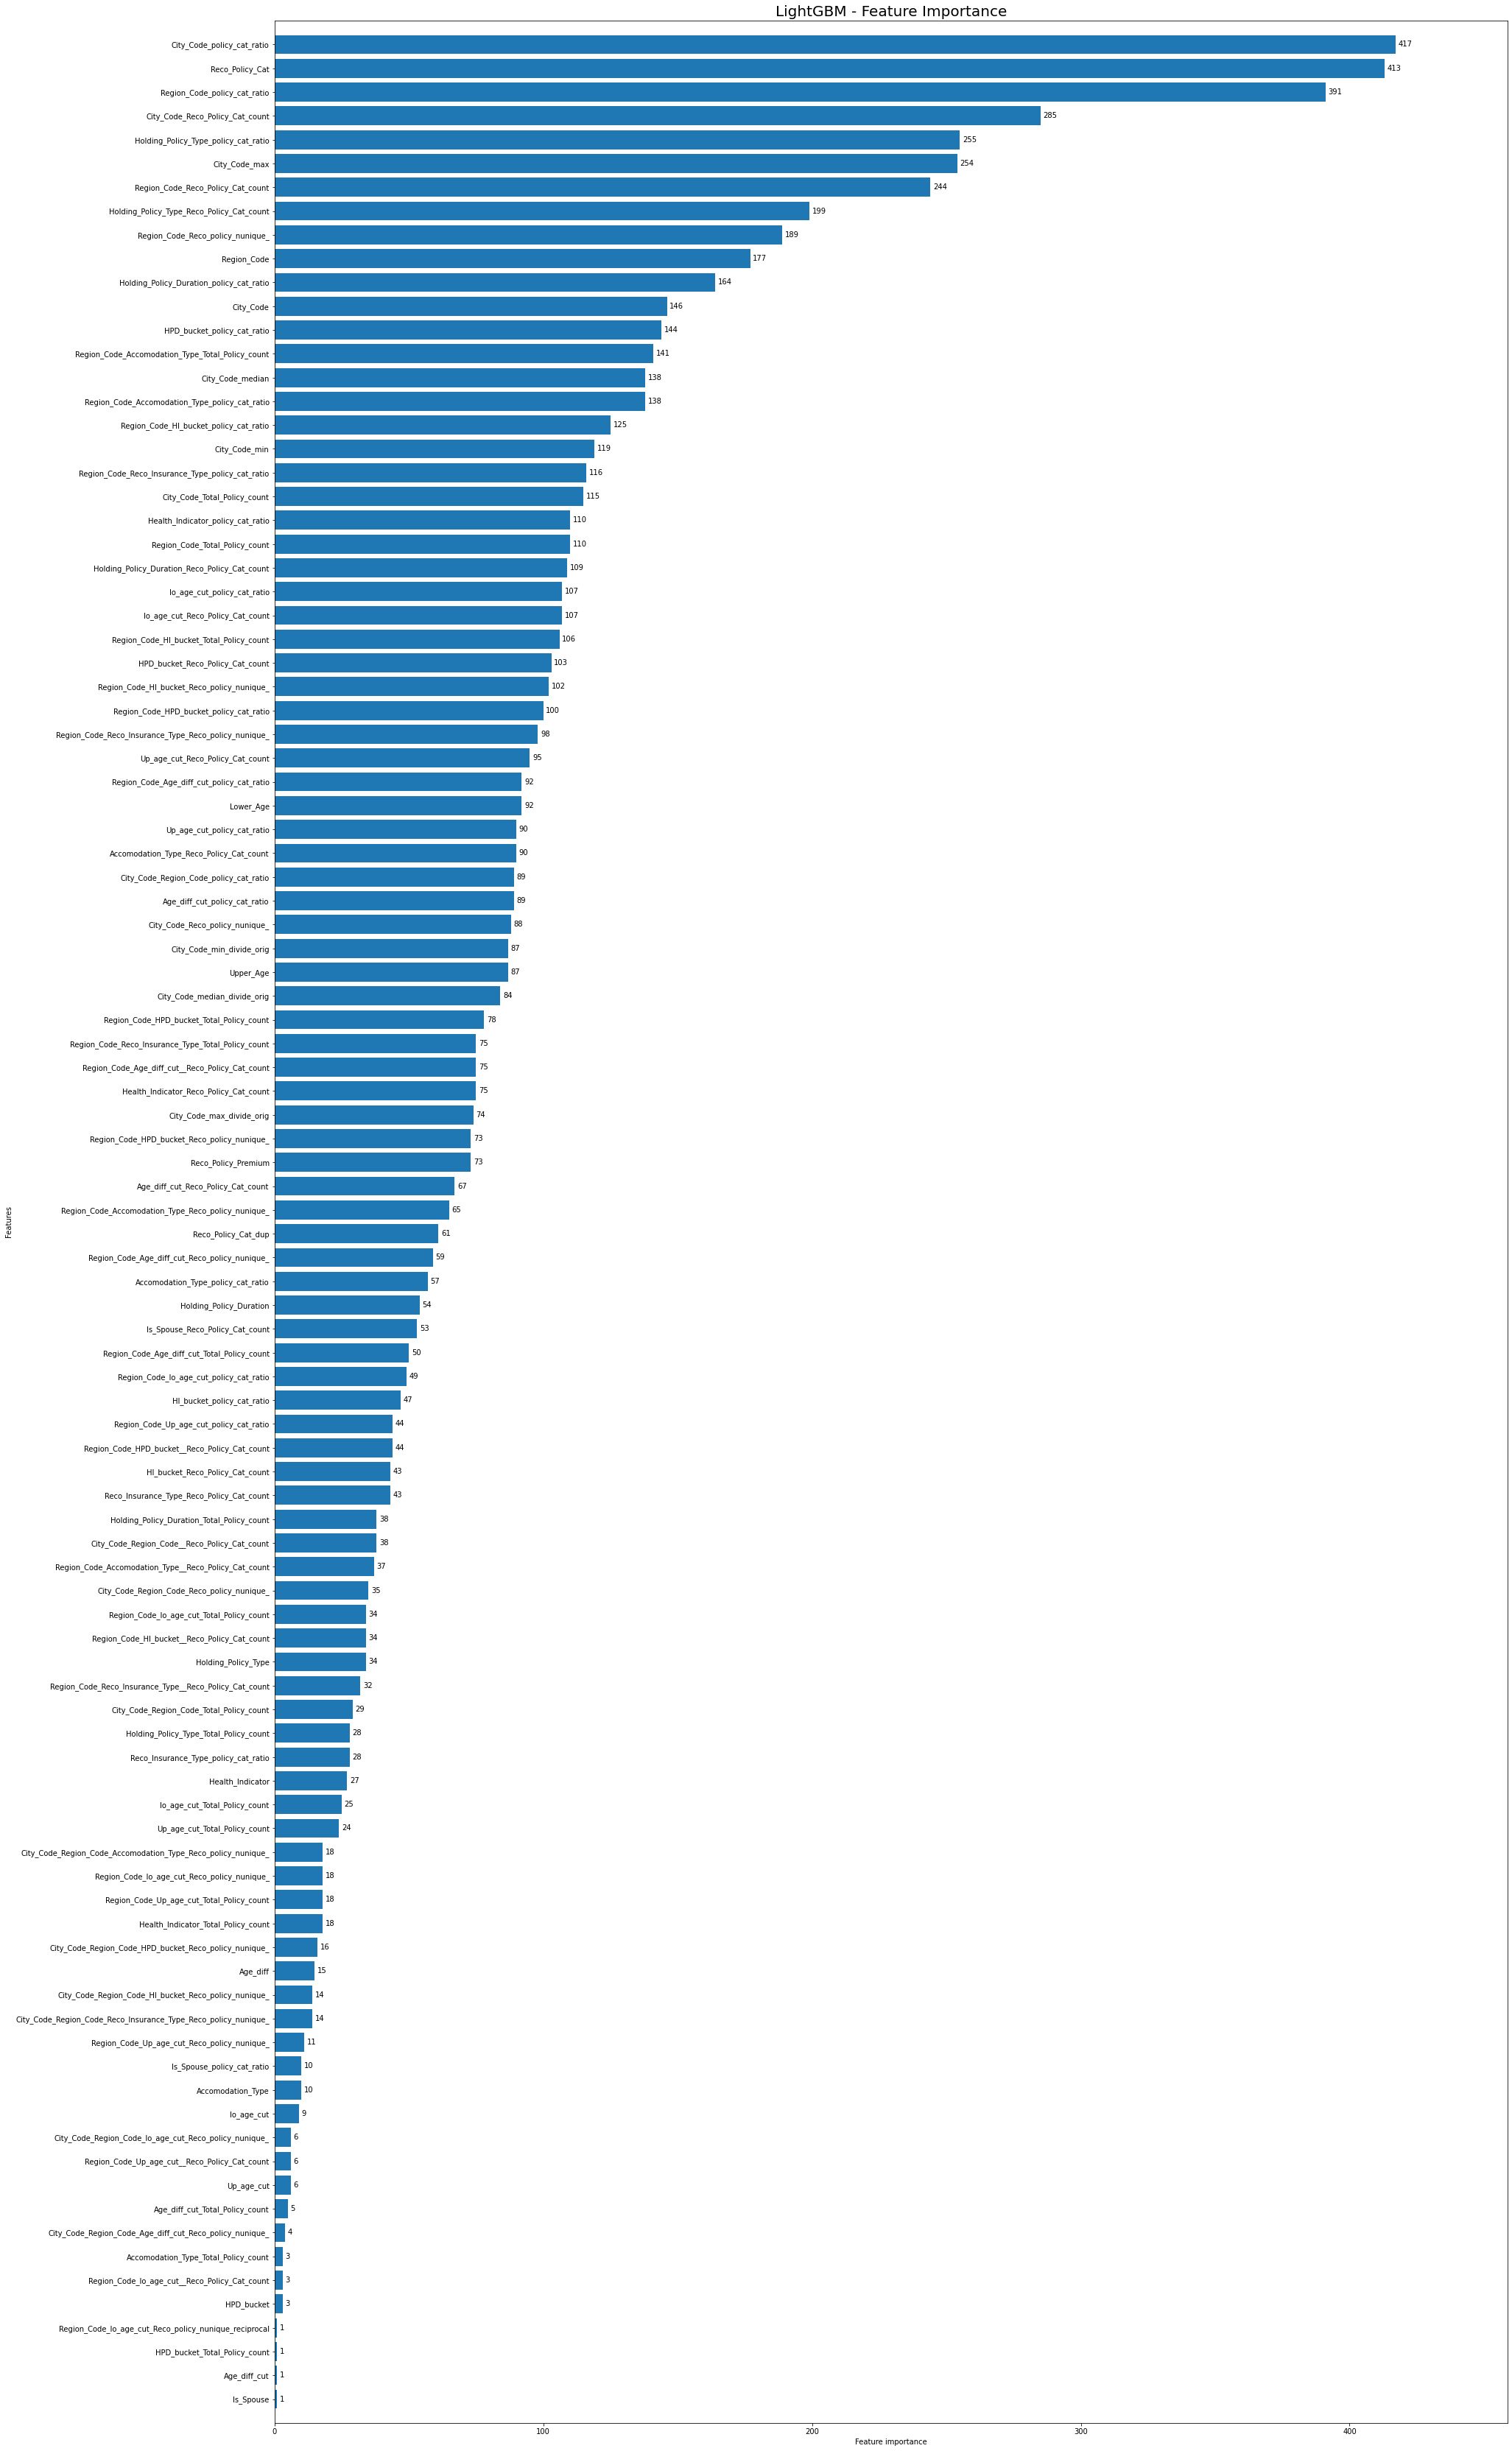

In [ ]:
fig, ax = plt.subplots(figsize=(30,60))
lgb.plot_importance(model, max_num_features=200, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=20)
plt.show()

## final prediction file

In [ ]:
sub = pd.DataFrame({'ID':test["ID"],'Response':pred_test_full})
sub.to_csv("Final_Submission.csv",index=False)